# TinyYolov3 HW implementation
https://www.learnpythonwithrune.org/how-to-get-started-with-yolo-in-python

## Import

In [4]:
from functions import *
from yolo_hw import *

ModuleNotFoundError: No module named 'qnn'

In [ ]:
%matplotlib inline

In [3]:
title = "tiny-yolo-test"
timer = Timer(title=title, verbose=verbose, report=True, filewrite=False, file=TIMELOG_PATH+os.sep+title+".csv")

NameError: name 'TIMELOG_PATH' is not defined

## Get list of all image files

In [ ]:
files = getListOfFiles(SOURCEIMAGES_PATH, False, True)
out = "## Files found:" + os.linesep
if verbose:
  for file in files:
    out += "  * {}".format(file) + os.linesep
print(out)

## Setup Yolo
This action will reprogam the FPGA partially

In [5]:
import ctypes
help(ctypes.c_char_p)

Help on class c_char_p in module ctypes:

class c_char_p(_ctypes._SimpleCData)
 |  XXX to be provided
 |  
 |  Method resolution order:
 |      c_char_p
 |      _ctypes._SimpleCData
 |      _ctypes._CData
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  from_param(...) from _ctypes.PyCSimpleType
 |      Convert a Python object into a function call parameter.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from _ctypes._SimpleCData:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __ctypes_from_outparam__(...)
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) f

In [6]:
timer.trigger("setup yolo begin")
(classifier, net, conv0_weights_correct, conv0_bias_broadcast, conv8_weights_correct, conv8_bias_broadcast, net_darknet) = setup_yolo_hw(PYTHON_PATH)
timer.end("setup yolo end", "Setup YOLO")

1. Instantiate a Classifier


## Execution on one file

2. Get image
  * /home/xilinx/jupyter_notebooks/mas_data/images/416px/factory_worker_5.jpg


3. Execute the first convolutional layer in Python


4. HW Offload of the quantized layers


5. Execute the last convolutional layer in Python


6. Draw detection boxes using Darknet
7. Show Probabilities
class: person	probability: 94%
class: person	probability: 88%
class: person	probability: 67%


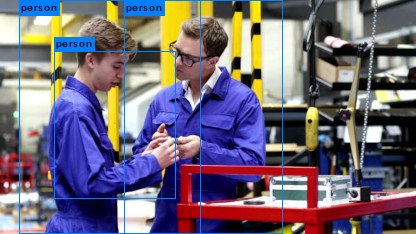

In [7]:
fname = "factory_worker_5.jpg"

timer.trigger("load image begin")
(fpath, npimg) = getFile(fname, SOURCEIMAGES_PATH, verbose)
timer.end("load image end", "Image Loading")

timer.trigger("yolo sw conv layer 0 begin") 
conv0_output_quant = execute_yolo_sw_firstlayer(npimg, conv0_weights_correct, conv0_bias_broadcast, verbose)
timer.end("yolo sw conv layer 0 end", "Apply YOLO SW Conv Layer 0")

timer.trigger("yolo hw conv layers 1-7 begin") 
conv_7_out = execute_yolo_hw(classifier, net, conv0_output_quant, verbose)
timer.end("yolo hw conv layers 1-7 end", "Apply YOLO HW Conv Layer 1-7")

timer.trigger("yolo sw conv layer 8 begin")
conv8_out = execute_yolo_sw_lastlayer(net, conv_7_out, conv8_weights_correct, conv8_bias_broadcast, verbose)
timer.end("yolo sw conv layer 8 end", "Apply YOLO SW Conv Layer 8")

timer.trigger("darknet detection begin")
(fpath_out, fpath_probs) = darknet_detection(fpath, OUT_PATH, conv8_out, DARKNET_PATH, net_darknet, verbose)
timer.end("darknet detection begin", "Draw Detection Boxes")

displayFile(fpath_out + OUT_EXT)
timer.dumpToCsv()

## Execution on multiple files

In [8]:
files = files[0:2]
for file in files:
  fname = os.path.split(file)[1]
  
  timer.trigger("load image begin")
  (fpath, npimg) = getFile(fname, SOURCEIMAGES_PATH, verbose)
  timer.end("load image end", "Image Loading")

  timer.trigger("yolo sw conv layer 0 begin") 
  conv0_output_quant = execute_yolo_sw_firstlayer(npimg, conv0_weights_correct, conv0_bias_broadcast, verbose)
  timer.end("yolo sw conv layer 0 end", "Apply YOLO SW Conv Layer 0")

  timer.trigger("yolo hw conv layers 1-7 begin") 
  conv_7_out = execute_yolo_hw(classifier, net, conv0_output_quant, verbose)
  timer.end("yolo hw conv layers 1-7 end", "Apply YOLO HW Conv Layer 1-7")

  timer.trigger("yolo sw conv layer 8 begin")
  conv8_out = execute_yolo_sw_lastlayer(net, conv_7_out, conv8_weights_correct, conv8_bias_broadcast, verbose)
  timer.end("yolo sw conv layer 8 end", "Apply YOLO SW Conv Layer 8")
  
  timer.trigger("darknet detection begin")
  (fpath_out, fpath_probs) = darknet_detection(fpath, OUT_PATH, conv8_out, DARKNET_PATH, net_darknet, verbose)
  timer.end("darknet detection begin", "Draw Detection Boxes")
  
  timer.dumpToCsv()

2. Get image
  * /home/xilinx/jupyter_notebooks/mas_data/images/416px/street_01_027.jpg


3. Execute the first convolutional layer in Python


4. HW Offload of the quantized layers


5. Execute the last convolutional layer in Python


6. Draw detection boxes using Darknet
7. Show Probabilities
class: train	probability: 62%


2. Get image
  * /home/xilinx/jupyter_notebooks/mas_data/images/416px/street_01_021.jpg


3. Execute the first convolutional layer in Python


4. HW Offload of the quantized layers


5. Execute the last convolutional layer in Python


6. Draw detection boxes using Darknet
7. Show Probabilities


### Display last Result

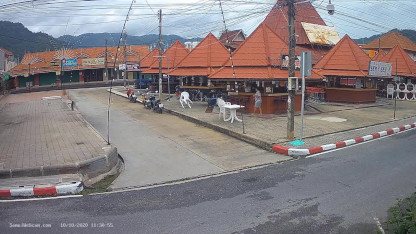

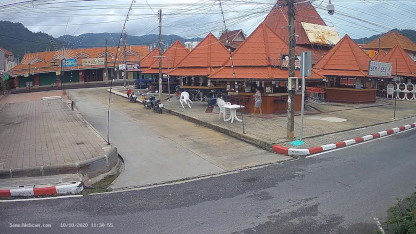

In [9]:
displayFile(fpath)
displayFile(fpath_out + OUT_EXT)

## 8. Performance analysis

The execution in mixed SW-HW design is profiled, and the performances in terms of latency and throughput are analysed and shown in the graph

In [7]:
## 8. Performance analysis
array = np.loadtxt('timestamp.txt')
array = list(map(lambda x: x/1000000, array))

MOPS=[171.3254,4385.99]
TIME=[array[0]+array[2],array[1]]
LABELS=["SW", "HW"]

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))

plt.yticks(x_pos, LABELS)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time [ms]")
ax1.set_ylabel("Platform")
ax1.barh(x_pos, TIME, height=0.6, color='g', zorder=3)
ax1.grid(zorder=0)

ax2.invert_yaxis()
ax2.set_xlabel("# of Operations [MOPS]")
ax2.barh(x_pos, MOPS, height=0.6, color='y', zorder=3)
ax2.grid(zorder=0)

MOPSS=[MOPS[i]/TIME[i] for i in range(len(MOPS))]
x_pos = np.arange(len(LABELS))
ax3.barh(x_pos, MOPSS, height=0.6, color='r', zorder=3)
ax3.invert_yaxis()
ax3.set_xlabel("Performances [MOPS/s]")
ax3.grid(zorder=0)
plt.show()

## Reset the device

In [10]:
classifier.deinit_accelerator()

In [11]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()